# Ultrasonic Sensor - Chirp Signal

A chirp signal in ultrasonic sensing is fundamentally different from a burst. While a burst is a short group of pulses at a fixed frequency, a chirp is a pulse whose frequency continuously sweeps during its duration, for example from 38Khz to 42 Khz over a few milliseconds. Chirp signals are widely used for improved resolution and noise immunity in applications like sonar and untrasonic ranging.

### What is a Chirp Signal?

A chirp signal is a sinosoidal waveform with a freqeuncy that varies over time - either linearly or non-linear (exponentially, hyperbolically, etc). For example, a linear chirp increases or decreases its frequenc at a constant rate.

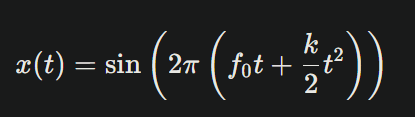

where f0 is the starting frequency and k is the frequency sweep rate.

### How to simulate a chirp signal in python

We can generate a chirp signal using the scipy.signal .chirp function, whioch lets you specify the starting frequency, ending frequency, time duration and sweep type. Here is how we can adapt the code to produce a chirp waveform.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

In [2]:
# Parameters
num_signals = 5              # How many chirps to send (simulate multiple pings)
burst_spacing = 0.001        # Time between each chirp burst (seconds) - 2 ms
num_pulses = 50             # How many cycles each chirp has
frequency = 40000            # Nominal frequency of Ultrasonic (Hz) - 40 kHz
sampling_rate = 1_000_000    # Sampling frequency for simulation - 1 MHz - very high for accuracy
f0 = 5000                    # Chirp starts at 5 Khz
f1 = 42000                   # Chirp ends at 42 Khz

duration = num_pulses / frequency                     # Length of each chirp signal in seconds 
samples_per_chirp = int(duration * sampling_rate)     # How many samples points per chirp
samples_between = int(burst_spacing * sampling_rate)  # How many zeros between chirps

print(f"One chirp duration: {duration:.6f} s, samples: {samples_per_chirp}")


One chirp duration: 0.001250 s, samples: 1250


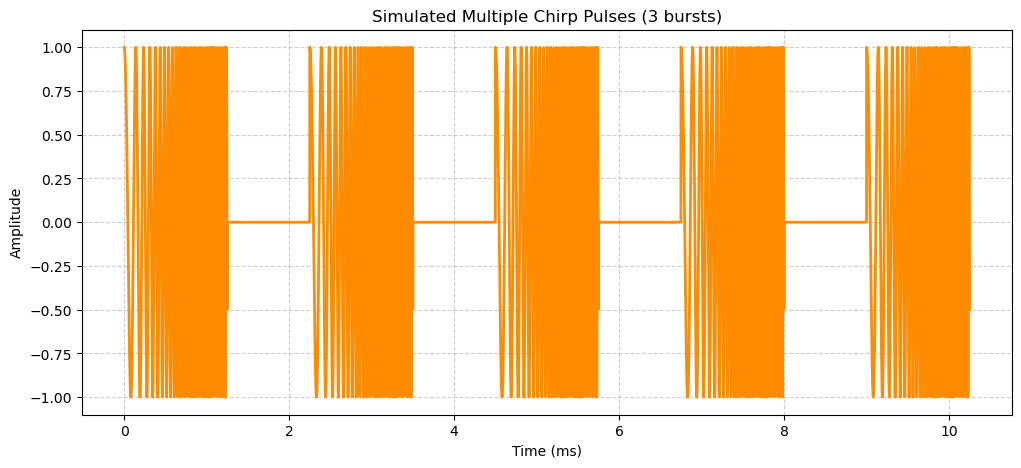

In [3]:
# Time array for one chirp
t_chirp = np.arange(0, duration, 1 / sampling_rate)
chirp_sig = chirp(t_chirp, f0=f0, f1=f1, t1=duration, method='linear')

# Build the composite signal - we repeat the chirp 3 times, separated by silences (zeros)
total_samples = num_signals * samples_per_chirp + (num_signals - 1) * samples_between
multi_signal = np.zeros(total_samples)

for i in range(num_signals):
    offset = i * (samples_per_chirp + samples_between)
    multi_signal[offset : offset + samples_per_chirp] = chirp_sig

# Time axis for composite signal
t_total = np.arange(0, total_samples) / sampling_rate

# Plot
plt.figure(figsize=(12, 5))
plt.plot(t_total * 1e3, multi_signal, color='darkorange', linewidth=2)
plt.title("Simulated Multiple Chirp Pulses (3 bursts)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Reflection of the Sent chirp

When a signal relects off an object, it comes back after a certain delay (the ToF). It is also weaker (attenuated) and there is always noise

* Distance is the sensor-to-reflector path (meters)
* Speed of sound in water is 1480 m/s 

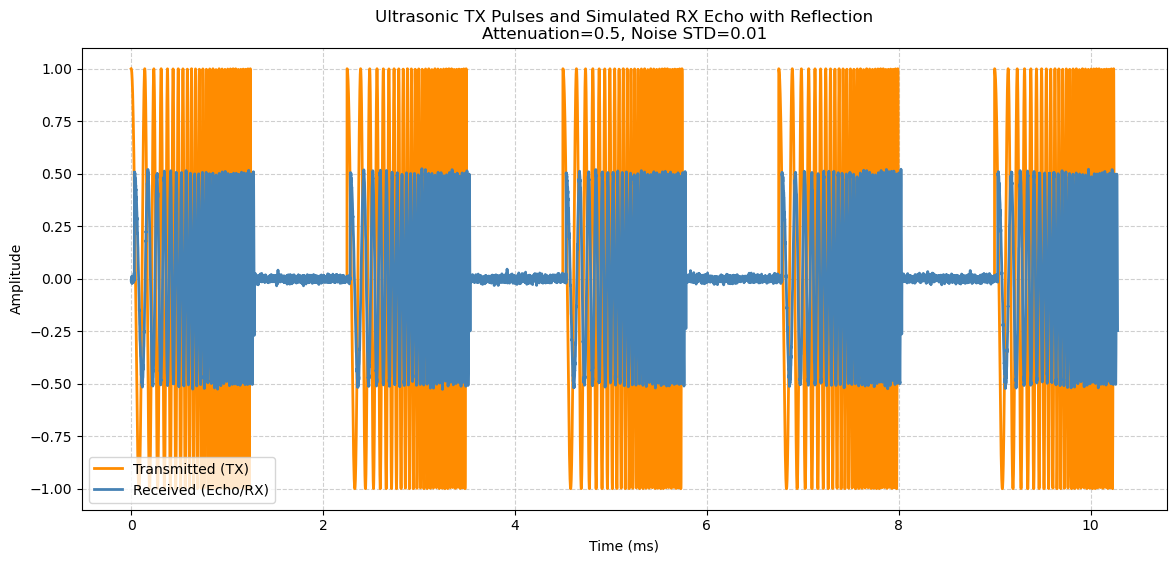

In [9]:
# Reflection simulation with adjustable attenuation and noise level

# Reflector distance (meters)
distance = 0.025       # 25 mm distance between pipe and reflector
speed_of_sound = 1480  # Speed of sound in water (m/s)
tof = 2 * distance / speed_of_sound  # Round trip time (seconds)
delay_samples = int(tof * sampling_rate)

# Adjustable parameters for distortion
attenuation = 0.5       # Echo reflection strength (0 = no echo, 1 = full strength)
noise_std = 0.01        # Noise standard deviation (0 = no noise)

# RX signal: delayed and attenuated echo + noise
rx_signal = np.zeros(len(multi_signal) + delay_samples)
rx_signal[delay_samples:delay_samples + len(multi_signal)] = attenuation * multi_signal
rx_signal += noise_std * np.random.randn(rx_signal.size)  # Add Gaussian noise

# Time axis for RX signal
t_rx = np.arange(rx_signal.size) / sampling_rate

# Plot both signals
plt.figure(figsize=(14, 6))
plt.plot(t_total * 1e3, multi_signal, label='Transmitted (TX)', c='darkorange', linewidth=2)
plt.plot(t_rx * 1e3, rx_signal, label='Received (Echo/RX)', c='steelblue', linewidth=2)
plt.title(f'Ultrasonic TX Pulses and Simulated RX Echo with Reflection\nAttenuation={attenuation}, Noise STD={noise_std}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

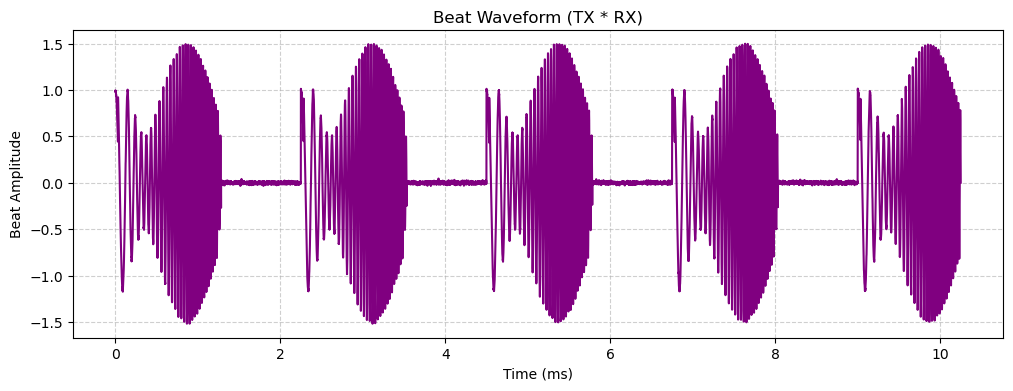

Estimated delay: 33 samples
Estimated ToF: 33.00 µs (0.000033 seconds)
Estimated distance: 0.024420 m


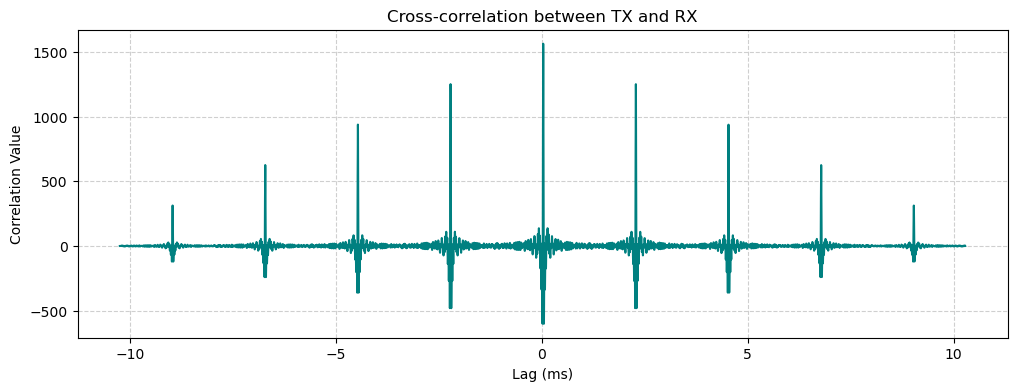

In [10]:
from scipy.signal import correlate

# --- 1. Beat waveform (mixing) ---
# Use only the non-padded length

min_len = min(len(multi_signal), len(rx_signal))
beat_waveform = multi_signal[:min_len] + rx_signal[:min_len]

plt.figure(figsize=(12, 4))
plt.plot(t_total[:min_len] * 1e3, beat_waveform, color='purple')
plt.title('Beat Waveform (TX * RX)')
plt.xlabel('Time (ms)')
plt.ylabel('Beat Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 2. Cross-correlation (for accurate TOF estimation) ---
corr = correlate(rx_signal, multi_signal, mode='full')
lags = np.arange(-len(multi_signal)+1, len(rx_signal))
delay_index = np.argmax(corr)
estimated_delay_samples = lags[delay_index]
estimated_delay_time_sec = estimated_delay_samples / sampling_rate
estimated_delay_time_us = estimated_delay_time_sec * 1e6  # microseconds

print(f"Estimated delay: {estimated_delay_samples} samples")
print(f"Estimated ToF: {estimated_delay_time_us:.2f} µs "
      f"({estimated_delay_time_sec:.6f} seconds)")

''' This is to verify the result '''
est_distance = (estimated_delay_time_us * 10**-6 * speed_of_sound)/2   ## divide by 2 is due to round trip

print (f"Estimated distance: {est_distance:.6f} m")

 
plt.figure(figsize=(12, 4))
plt.plot(lags / sampling_rate * 1e3, corr, color='teal')
plt.title('Cross-correlation between TX and RX')
plt.xlabel('Lag (ms)')
plt.ylabel('Correlation Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Model Validation 

=== Ground-truth check ===
Expected ToF (s): 0.000033784  Expected samples (approx): 33.78
Measured ToF (s): 0.000033000  Measured samples: 33
Absolute sample error: -0.78 samples
Distance error (m): -0.000580 m

=== Peak strength metrics ===
Peak value (env)        : 9.3816e+02
Median env              : 1.4851e+01, std env: 6.0387e+01
Peak/median             : 63.17
(Peak - median)/std     : 15.29   (SNR-like metric)
Peak-to-Sidelobe Ratio  : 65.54

=== Earliest significant arrival near expected window ===
First candidate lag (samples): -7
Measured lag (samples)       : 33

=== Residual check ===
Estimated amplitude (least-squares): 0.3001
RMS before subtraction: 3.4488e-01
RMS after subtraction : 3.0262e-01
RMS reduction (dB)    : 1.14 dB
Small RMS reduction -> detection may be wrong or echo model mismatch.

=== GCC-PHAT check ===
GCC-PHAT estimated lag (samples): 35
Matched-filter measured samples   : 33
Note: check sign conventions if numbers disagree by sign.

=== Repeatability (b

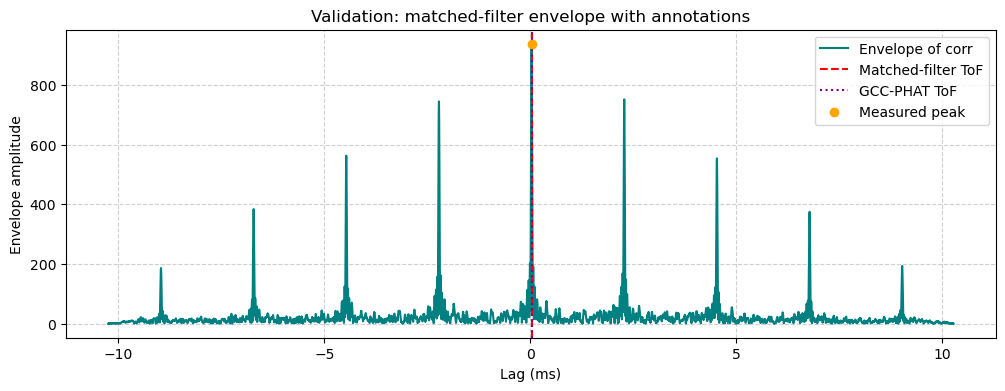

=== Final verdict (heuristic) ===
HIGH CONFIDENCE: ToF estimate looks correct.


In [6]:
# ---------------------------
# Validation block (append to end)
# ---------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, find_peaks
from numpy.fft import rfft, irfft, fft, ifft

# Ensure corr and lags exist (they should from your code). If not, recompute:
# corr = correlate(rx_signal, multi_signal, mode='full')
# lags = np.arange(-len(multi_signal)+1, len(rx_signal))

# 1) Ground-truth comparison
expected_tof_sec = 2 * distance / speed_of_sound
expected_samples = expected_tof_sec * sampling_rate  # float
expected_samples_int = int(round(expected_samples))

measured_samples = estimated_delay_samples
measured_tof_sec = measured_samples / sampling_rate

print("=== Ground-truth check ===")
print(f"Expected ToF (s): {expected_tof_sec:.9f}  Expected samples (approx): {expected_samples:.2f}")
print(f"Measured ToF (s): {measured_tof_sec:.9f}  Measured samples: {measured_samples}")
print(f"Absolute sample error: {measured_samples - expected_samples:.2f} samples")
print(f"Distance error (m): {(measured_tof_sec - expected_tof_sec) * speed_of_sound / 2:.6f} m")
print()

# 2) Envelope and peak SNR / PSR
env = np.abs(hilbert(corr))
# corr_index is index into corr corresponding to measured peak:
# corr index 0 corresponds to lag = -len(multi_signal)+1
corr_index = np.where(lags == measured_samples)[0]
corr_index = int(corr_index[0]) if corr_index.size else None
# If we detected refined via interpolation some code used rounding; handle fallback by finding nearest peak
if corr_index is None:
    corr_index = np.argmax(corr)

peak_val = env[corr_index]
median_env = np.median(env)
std_env = np.std(env)
peak_to_median = peak_val / (median_env + 1e-12)
peak_to_std = (peak_val - median_env) / (std_env + 1e-12)

# compute PSR (exclude a small window around the peak)
exclude_samples = int(0.0005 * sampling_rate)  # 0.5 ms
i_low = max(0, corr_index - exclude_samples)
i_high = min(len(env), corr_index + exclude_samples)
sidelobes = np.concatenate([env[:i_low], env[i_high:]]) if i_low>0 or i_high<len(env) else env
psr = peak_val / (np.median(sidelobes) + 1e-12)

print("=== Peak strength metrics ===")
print(f"Peak value (env)        : {peak_val:.4e}")
print(f"Median env              : {median_env:.4e}, std env: {std_env:.4e}")
print(f"Peak/median             : {peak_to_median:.2f}")
print(f"(Peak - median)/std     : {peak_to_std:.2f}   (SNR-like metric)")
print(f"Peak-to-Sidelobe Ratio  : {psr:.2f}")
print()

# 3) Earliest above-threshold arrival (prefer earliest significant peak for direct path)
# define search window around expected sample
margin = int(0.0006 * sampling_rate)  # ±0.6 ms
# convert expected_samples to lag index in corr array:
expected_lag = int(round(expected_samples))
# corr index for expected_lag:
expected_corr_i = np.where(lags == expected_lag)[0]
expected_corr_i = int(expected_corr_i[0]) if expected_corr_i.size else None
search_start = max(0, (expected_corr_i or 0) - margin)
search_end = min(len(env), (expected_corr_i or 0) + margin)
candidates, cprops = find_peaks(env[search_start:search_end],
                                height=median_env + 2.5 * std_env, prominence=1.5*std_env)
if len(candidates) > 0:
    first_candidate_corr_idx = search_start + candidates[0]
    first_candidate_lag = lags[first_candidate_corr_idx]
    print("=== Earliest significant arrival near expected window ===")
    print(f"First candidate lag (samples): {first_candidate_lag}")
    print(f"Measured lag (samples)       : {measured_samples}")
    # If first candidate is earlier than measured, warn that measured may be strongest multipath
    if first_candidate_lag < measured_samples:
        print("Warning: detected peak is later than an earlier significant arrival -> multipath may dominate strongest peak.")
    else:
        print("Detected peak appears to be earliest significant arrival in search window.")
else:
    print("No early candidate found in expected window (try widening margin or lowering threshold).")
print()

# 4) Residual reconstruction: create best-fit scaled echo and compute RMS reduction
# compute optimal amplitude scale via least-squares for overlap region
rx_len = len(rx_signal)
tx_len = len(multi_signal)
start_idx = measured_samples
end_idx = start_idx + tx_len
if start_idx < 0:
    print("Measured start negative — cannot synthesize residual.")
else:
    # ensure bounds
    end_idx = min(end_idx, rx_len)
    valid_tx_len = end_idx - start_idx
    if valid_tx_len <= 0:
        print("Measured peak out of RX range — cannot synthesize residual.")
    else:
        # take the RX slice where the synth echo would lie
        rx_slice = rx_signal[start_idx:end_idx]
        tx_slice = multi_signal[:valid_tx_len]
        # least squares amplitude: alpha = dot(rx_slice, tx_slice)/dot(tx_slice, tx_slice)
        denom = np.dot(tx_slice, tx_slice)
        alpha = np.dot(rx_slice, tx_slice) / (denom + 1e-12)
        synth = np.zeros_like(rx_signal)
        synth[start_idx:start_idx+valid_tx_len] = alpha * tx_slice
        residual = rx_signal - synth
        rms_before = np.sqrt(np.mean(rx_signal**2))
        rms_after = np.sqrt(np.mean(residual**2))
        reduction_db = 20*np.log10((rms_before + 1e-12) / (rms_after + 1e-12))
        print("=== Residual check ===")
        print(f"Estimated amplitude (least-squares): {alpha:.4f}")
        print(f"RMS before subtraction: {rms_before:.4e}")
        print(f"RMS after subtraction : {rms_after:.4e}")
        print(f"RMS reduction (dB)    : {reduction_db:.2f} dB")
        if reduction_db > 3:
            print("Good: significant RMS reduction after removing synthesized echo -> detection likely correct.")
        else:
            print("Small RMS reduction -> detection may be wrong or echo model mismatch.")
print()

# 5) GCC-PHAT independent estimator
def gcc_phat(x, y, fs, max_tau=None, interp=1):
    """
    Return estimated lag (in samples) using GCC-PHAT between x and y.
    """
    n = x.size + y.size
    # FFT
    X = fft(x, n=n)
    Y = fft(y, n=n)
    R = X * np.conj(Y)
    R /= (np.abs(R) + 1e-12)  # PHAT weighting
    cc = np.real(ifft(R))
    cc = np.fft.fftshift(cc)
    # build lag array
    max_shift = int(n//2)
    lags_g = np.arange(-max_shift, max_shift)
    # pick maximum
    idx = np.argmax(np.abs(cc))
    tau = lags_g[idx]
    return tau, cc, lags_g

# compute GCC-PHAT using tx=multi_signal, rx=rx_signal (or window around expected to save compute)
tau, cc_phat, lags_g = gcc_phat(rx_signal, multi_signal, sampling_rate)
print("=== GCC-PHAT check ===")
print(f"GCC-PHAT estimated lag (samples): {tau}")
# convert tau into our lag-space convention: gcc returns shift where positive tau means rx lags tx by tau
# Compare signs/values: our measured_samples should be close to tau
print(f"Matched-filter measured samples   : {measured_samples}")
print("Note: check sign conventions if numbers disagree by sign.")
print()

# 6) Repeatability: short bootstrap by adding small noise and re-running matched-filter detection
def detect_from_rx(rx_input):
    # simple detection: bandpass -> correlate -> pick max of envelope
    # Recompute corr for given rx_input (no stacking)
    # Reuse earlier bandpass settings f0/f1
    from scipy.signal import butter, filtfilt
    def band(signal, fs, low, high, order=4):
        b,a = butter(order, [low/(0.5*fs), high/(0.5*fs)], btype='band')
        return filtfilt(b,a,signal)
    tx_b = band(multi_signal, sampling_rate, f0, f1)
    rx_b = band(rx_input, sampling_rate, f0, f1)
    c = np.abs(hilbert(correlate(rx_b, tx_b, mode='full')))
    idx = np.argmax(c)
    lag = lags[idx]  # uses same lags as before since lengths unchanged
    return lag

Nboot = 30
lags_boot = []
for i in range(Nboot):
    # perturb current rx_signal with small Gaussian noise (bootstrap)
    pert = rx_signal + 0.01 * np.std(rx_signal) * np.random.randn(len(rx_signal))
    try:
        l = detect_from_rx(pert)
        lags_boot.append(l)
    except Exception:
        pass

if len(lags_boot) > 0:
    lags_boot = np.array(lags_boot)
    print("=== Repeatability (bootstrap) ===")
    print(f"Bootstrap N={len(lags_boot)}   mean samples={lags_boot.mean():.2f}   std samples={lags_boot.std():.2f}")
    print(f"Bootstrap mean error (m): {(lags_boot.mean()/sampling_rate*speed_of_sound/2 - distance):.6f}")
    if lags_boot.std() < 2.0:
        print("Good repeatability (std < 2 samples).")
    else:
        print("High variance in repeated estimates -> detection not stable.")
else:
    print("Bootstrap failed (no detections).")
print()

# 7) Plot envelope and annotate: measured peak and GCC-PHAT (if within plotting lags)
plt.figure(figsize=(12,4))
lag_times_ms = lags / sampling_rate * 1e3
plt.plot(lag_times_ms, env, label='Envelope of corr', color='teal')
plt.axvline(measured_samples/sampling_rate*1e3, color='r', linestyle='--', label='Matched-filter ToF')
# mark GCC-PHAT converted into same axis if within range
# Note: gcc_tau's sign conv may differ. We'll plot its time if magnitude reasonable
gcc_time_ms = tau / sampling_rate * 1e3
if np.abs(tau) < 0.5 * len(lags):  # sanity check
    plt.axvline(gcc_time_ms, color='purple', linestyle=':', label='GCC-PHAT ToF')
plt.scatter(lag_times_ms[corr_index], env[corr_index], c='orange', zorder=5, label='Measured peak')
plt.xlabel('Lag (ms)')
plt.ylabel('Envelope amplitude')
plt.title('Validation: matched-filter envelope with annotations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 8) Final verdict heuristics
print("=== Final verdict (heuristic) ===")
score = 0
if abs(measured_samples - expected_samples) < 5:        # within 5 samples
    score += 2
if peak_to_std > 4.0:
    score += 2
if psr > 3.0:
    score += 1
if 'reduction_db' in locals() and reduction_db > 3:
    score += 2
if 'lags_boot' in locals() and len(lags_boot)>0 and np.nanstd(lags_boot) < 3:
    score += 1
# interpret
if score >= 6:
    print("HIGH CONFIDENCE: ToF estimate looks correct.")
elif score >= 3:
    print("MEDIUM CONFIDENCE: ToF may be correct but double-check or calibrate.")
else:
    print("LOW CONFIDENCE: ToF estimate is likely unreliable. Consider stacking, filtering or other estimators.")
